In [1]:
!rm -r /content/sample_data

In [2]:
!unzip '/content/dataset.zip'

Archive:  /content/dataset.zip
   creating: dataset/
   creating: dataset/detection/
  inflating: dataset/detection/1.jpg  
  inflating: dataset/detection/10.jpg  
  inflating: dataset/detection/100.jpg  
  inflating: dataset/detection/101.jpg  
  inflating: dataset/detection/102.jpg  
  inflating: dataset/detection/103.jpg  
  inflating: dataset/detection/104.jpg  
  inflating: dataset/detection/105.jpg  
  inflating: dataset/detection/106.jpg  
  inflating: dataset/detection/107.jpg  
  inflating: dataset/detection/108.jpg  
  inflating: dataset/detection/109.jpg  
  inflating: dataset/detection/11.jpg  
  inflating: dataset/detection/110.jpg  
  inflating: dataset/detection/111.jpg  
  inflating: dataset/detection/112.jpg  
  inflating: dataset/detection/113.jpg  
  inflating: dataset/detection/114.jpg  
  inflating: dataset/detection/115.jpg  
  inflating: dataset/detection/116.jpg  
  inflating: dataset/detection/117.jpg  
  inflating: dataset/detection/118.jpg  
  inflating: data

In [ ]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!pip install ultralytics
!pip install torch torchvision
!pip install efficientnet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.0/950.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
## Number Plate Detection Model

In [ ]:
# Data preperation for Yolo model

In [4]:
import os
import pandas as pd
import random
import shutil
import cv2

# Paths
dataset_dir = "/content/dataset/detection"
csv_file = "/content/dataset/detection.csv"
output_dir = "/content/dataset/yolo"
train_images_dir = os.path.join(output_dir, "train/images")
train_labels_dir = os.path.join(output_dir, "train/labels")
valid_images_dir = os.path.join(output_dir, "valid/images")
valid_labels_dir = os.path.join(output_dir, "valid/labels")
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(valid_images_dir, exist_ok=True)
os.makedirs(valid_labels_dir, exist_ok=True)

# Load CSV
df = pd.read_csv(csv_file)

# Shuffle and Split Dataset
image_ids = df['img_id'].unique()
random.shuffle(image_ids)
split_idx = int(len(image_ids) * 0.8)
train_ids = image_ids[:split_idx]
valid_ids = image_ids[split_idx:]

# Function to Convert Bounding Boxes to YOLO Format
def convert_to_yolo(row, img_width, img_height):
    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']
    x_center = ((xmin + xmax) / 2) / img_width
    y_center = ((ymin + ymax) / 2) / img_height
    bbox_width = (xmax - xmin) / img_width
    bbox_height = (ymax - ymin) / img_height
    return f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Process Images and Annotations
for img_id in image_ids:
    img_path = os.path.join(dataset_dir, img_id)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img_height, img_width, _ = img.shape
    annotations = df[df['img_id'] == img_id]

    yolo_annotations = []
    for _, row in annotations.iterrows():
        yolo_annotations.append(convert_to_yolo(row, img_width, img_height))

    # Determine Destination
    if img_id in train_ids:
        dest_img_dir = train_images_dir
        dest_label_dir = train_labels_dir
    else:
        dest_img_dir = valid_images_dir
        dest_label_dir = valid_labels_dir

    # Save Image and Annotation
    shutil.copy(img_path, os.path.join(dest_img_dir, img_id))
    label_file = os.path.join(dest_label_dir, img_id.replace('.jpg', '.txt'))
    with open(label_file, 'w') as f:
        f.write("\n".join(yolo_annotations))

# Create YAML File
yaml_content = f"""
path: {output_dir}
train: train/images
val: valid/images
names:
  0: license_plate
"""
yaml_path = os.path.join(output_dir, "detection_data.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("YOLO dataset preparation complete!")


YOLO dataset preparation complete!


In [ ]:
# Visualization of dataset

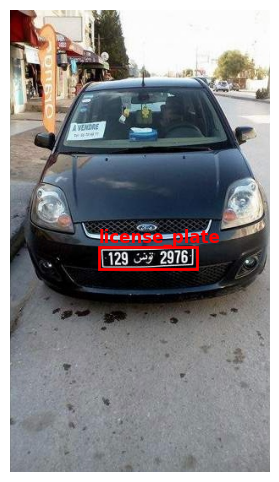

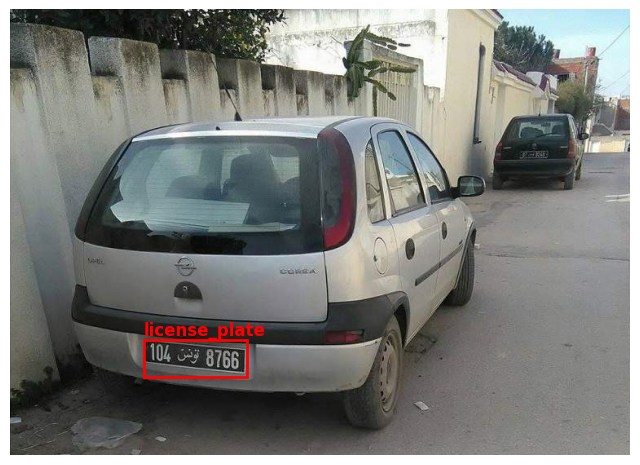

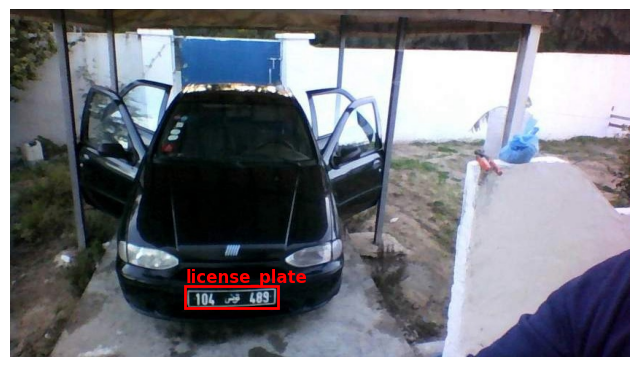

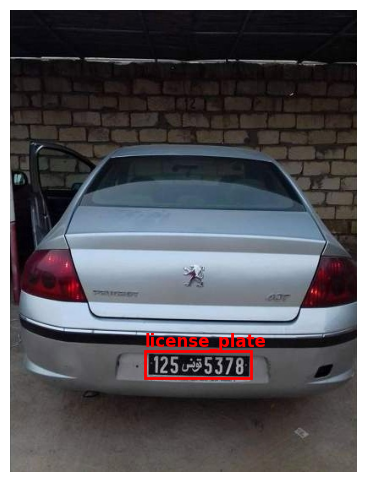

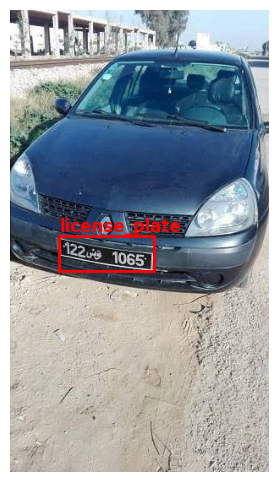

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths to Dataset
train_images_dir = "/content/dataset/yolo/train/images"
train_labels_dir = "/content/dataset/yolo/train/labels"

# Class Names (from YAML file)
class_names = ["license_plate"]  # Update this if you have more classes

# Function to Plot an Image with Bounding Boxes
def plot_sample(image_path, label_path):
    # Read Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read Label File
    with open(label_path, "r") as f:
        labels = f.readlines()

    # Plot Image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)

    # Add Bounding Boxes
    height, width, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        xmin = int(x_center - bbox_width / 2)
        xmax = int(x_center + bbox_width / 2)
        ymin = int(y_center - bbox_height / 2)
        ymax = int(y_center + bbox_height / 2)

        # Draw Bounding Box
        plt.gca().add_patch(
            plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                          edgecolor='red', linewidth=2, facecolor='none')
        )
        # Add Class Label
        plt.text(xmin, ymin - 5, class_names[int(class_id)],
                 color='red', fontsize=12, weight='bold')

    plt.axis("off")
    plt.show()

# Get a Couple of Samples
samples = os.listdir(train_images_dir)[:5]  # Fetch first 5 images for visualization
for sample in samples:
    img_path = os.path.join(train_images_dir, sample)
    label_path = os.path.join(train_labels_dir, sample.replace(".jpg", ".txt"))

    # Plot Training Sample
    plot_sample(img_path, label_path)


In [6]:
from ultralytics import YOLO
import os
yaml_file = '/content/dataset/yolo/detection_data.yaml'
# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Using a YOLOv8 nano pretrained model (fast and lightweight)

# Train the model
model.train(data=yaml_file, epochs=10, imgsz=640, batch=16)

# Save the trained model
model.export(format="onnx")  # Optional: Export the model to ONNX format for deployment
print("Detection model training complete!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.9MB/s]


Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/yolo/detection_data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 10.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.0MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/yolo/train/labels... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:00<00:00, 2145.25it/s]

train: New cache created: /content/dataset/yolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/yolo/valid/labels... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 1663.63it/s]

val: New cache created: /content/dataset/yolo/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.04G      1.228      2.943      1.162         16        640: 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

                   all        180        180    0.00333          1      0.537       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.55G      1.175      1.831      1.045         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

                   all        180        180      0.887      0.873      0.933      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.57G      1.156      1.536      1.043         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


                   all        180        180      0.954      0.916      0.975      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.59G      1.109      1.265      1.036         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


                   all        180        180      0.987      0.972      0.992      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.61G      1.064      1.076     0.9921         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

                   all        180        180      0.946      0.974      0.969      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.62G       1.03     0.9384     0.9925         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all        180        180      0.993      0.983      0.993      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.64G     0.9625     0.8374     0.9577         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

                   all        180        180          1      0.972      0.992      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.66G     0.9402     0.7686     0.9459         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]

                   all        180        180      0.993      0.978      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.67G     0.9221     0.7084     0.9316         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


                   all        180        180      0.998      0.994      0.995      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.69G     0.8725     0.6695     0.9158         16        640: 100%|██████████| 45/45 [00:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]

                   all        180        180      0.983      0.985      0.994      0.775



10 epochs completed in 0.041 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


                   all        180        180      0.983      0.985      0.994      0.775
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.98 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.30GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 169.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 322.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 209.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 249.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.

In [ ]:
## Recognition

In [ ]:
# visulization

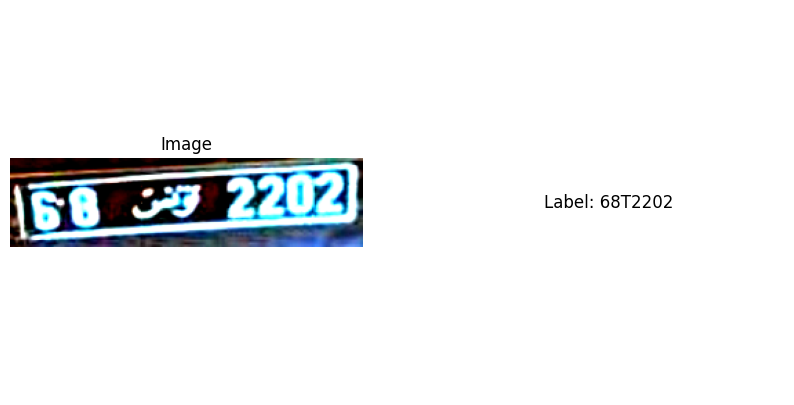

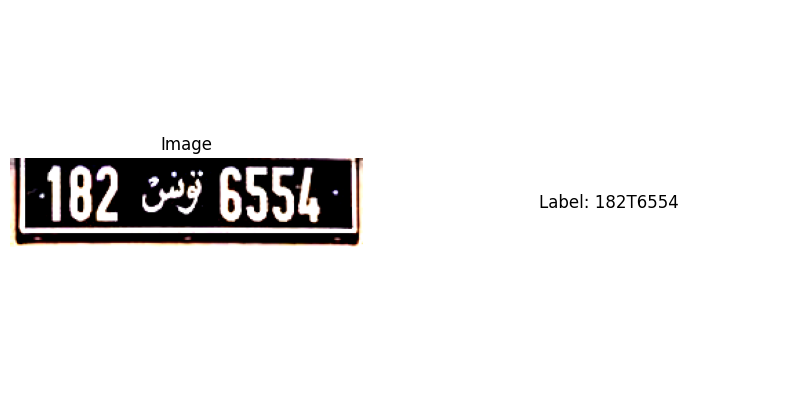

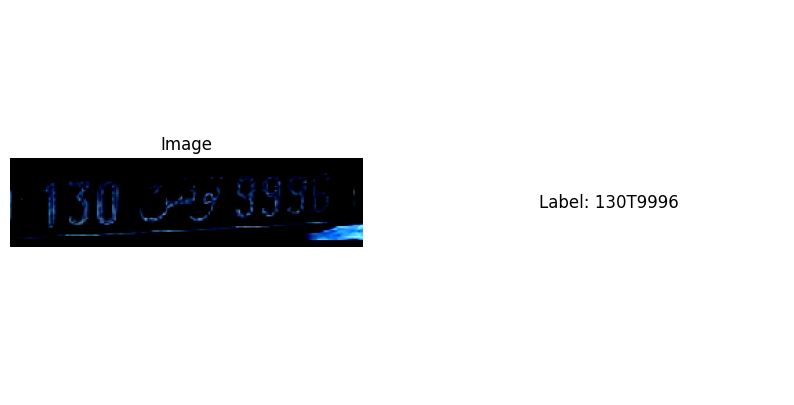

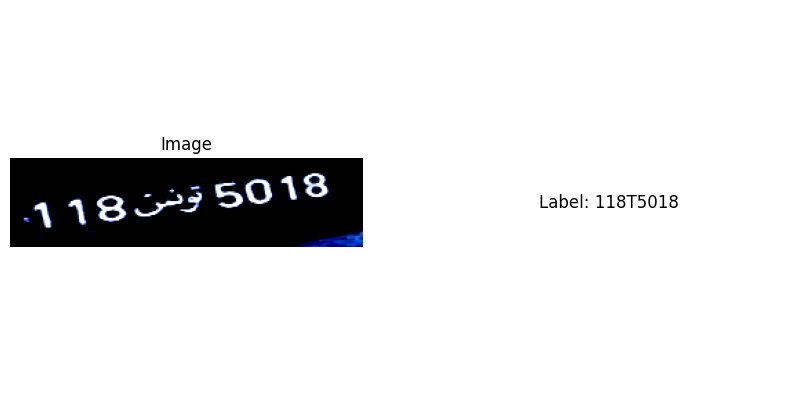

In [7]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define the alphabet and <blank> character for CTC loss
alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Example for alphanumeric license plates
alphabet = list(alphabet) + ['<blank>']

# Custom Dataset class
class NumberPlateDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])  # img_id
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx, 1]  # text

        # Convert the label into a list of integer indices corresponding to each character in the alphabet
        label_indices = [alphabet.index(char) for char in label]
        label_tensor = torch.IntTensor(label_indices)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# Define transformations to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset and dataloader
dataset = NumberPlateDataset(csv_file='/content/dataset/recognition.csv', img_dir='/content/dataset/recognition', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Batch size 1 to visualize a single sample

# Function to display one image and its label
def show_image_with_label():
    for i, (images, labels) in enumerate(dataloader):
        if i:  # Show the first image in the batch
            # Convert the image tensor back to numpy array for visualization
            image = images[0].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
            label = ''.join([alphabet[idx.item()] for idx in labels[0] if idx != alphabet.index('<blank>')])

            # Plot the image and label side by side
            plt.figure(figsize=(10, 5))

            # Plot the image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Image")
            plt.axis('off')

            # Plot the label
            plt.subplot(1, 2, 2)
            plt.text(0.5, 0.5, f"Label: {label}", fontsize=12, ha='center', va='center')
            plt.axis('off')

            plt.show()
        if i >= 4:  # Display only the first few batches
            break
            #break  # Only show one image and label

# Show the image with its label
show_image_with_label()


In [ ]:
## Training Efficientnet Model for Recognition

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CTCLoss
from PIL import Image
import os
import pandas as pd

# Define the alphabet and <blank> character for CTC loss
alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Example for alphanumeric license plates
alphabet = list(alphabet) + ['<blank>']

# Custom Dataset class
class NumberPlateDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])  # img_id
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx, 1]  # text

        # Convert the label into a list of integer indices corresponding to each character in the alphabet
        label_indices = [alphabet.index(char) for char in label]
        label_tensor = torch.IntTensor(label_indices)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# Define transformations to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Custom collate_fn to handle padding in labels
def collate_fn(batch):
    images, labels = zip(*batch)

    max_length = max([len(label) for label in labels])
    padded_labels = [torch.cat([label, torch.zeros(max_length - len(label), dtype=torch.long)]) for label in labels]

    images = torch.stack(images, dim=0)
    padded_labels = torch.stack(padded_labels, dim=0)

    return images, padded_labels

# Load dataset and dataloader
dataset = NumberPlateDataset(csv_file='/content/dataset/recognition.csv', img_dir='/content/dataset/recognition', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


# EfficientNet Model for Number Plate Recognition with Sequence Output
class EfficientNetOCR(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetOCR, self).__init__()
        # Load a pre-trained EfficientNetB0 model
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')

        # We will use a Sequential layer to treat the output as a sequence of classes
        self.seq_head = nn.Sequential(
            nn.Linear(self.backbone._fc.in_features, 128),  # Fully connected layer to reduce feature space
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output layer for classification
        )

    def forward(self, x):
        # Get the features from EfficientNet
        x = self.backbone.extract_features(x)
        # Here, we assume the extracted features can be treated as sequences for CTC Loss
        # The feature map is flattened across the spatial dimensions (H, W), but we want to keep sequence dimension (W).
        x = x.view(x.size(0), -1, x.size(1))  # Reshape to (batch_size, seq_len, num_features)
        # Apply the sequential head to each time step (each seq position)
        x = self.seq_head(x)
        return x

# Initialize the model and move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
model = EfficientNetOCR(num_classes=len(alphabet)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
ctc_loss = CTCLoss(blank=alphabet.index('<blank>'), zero_infinity=True)

# Training Loop
def train_model(model, dataloader, optimizer, ctc_loss, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)  # (batch_size, seq_len, num_classes)

            # Ensure correct shape for CTC Loss
            outputs = outputs.permute(1, 0, 2)  # Change shape from (batch_size, seq_len, num_classes) to (seq_len, batch_size, num_classes)

            # Define output and label lengths
            output_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(device)  # Tensors of sequence length
            label_lengths = torch.full((images.size(0),), labels.size(1), dtype=torch.long).to(device)  # Length of each label

            # Compute CTC Loss
            loss = ctc_loss(outputs.log_softmax(dim=2), labels, output_lengths, label_lengths)
            epoch_loss += loss.item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}')
        # Save the trained model
        torch.save(model.state_dict(), 'efficientnet_ocr.pth')


# Train the model
train_model(model, dataloader, optimizer, ctc_loss, num_epochs=20)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 151MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch [1/20], Loss: 4.1598610961646365
Epoch [2/20], Loss: 2.662152001732274
Epoch [3/20], Loss: 2.3341727842364395
Epoch [4/20], Loss: 2.14139061225088
Epoch [5/20], Loss: 2.0452228742733336
Epoch [6/20], Loss: 1.930503293087608
Epoch [7/20], Loss: 1.780371067816751
Epoch [8/20], Loss: 1.5840395312560231
Epoch [9/20], Loss: 1.375002620512979
Epoch [10/20], Loss: 1.1739223839943869
Epoch [11/20], Loss: 0.9859165068258319
Epoch [12/20], Loss: 0.8218639628929004
Epoch [13/20], Loss: 0.6778899593311444
Epoch [14/20], Loss: 0.5312372299662808
Epoch [15/20], Loss: 0.4244957425092396
Epoch [16/20], Loss: 0.3394881032015148
Epoch [17/20], Loss: 0.2713643769946015
Epoch [18/20], Loss: 0.22868724402628446
Epoch [19/20], Loss: 0.17075589521412263
Epoch [20/20], Loss: 0.14200103544352347


In [ ]:
#Inference for Recognition model

Loaded pretrained weights for efficientnet-b0


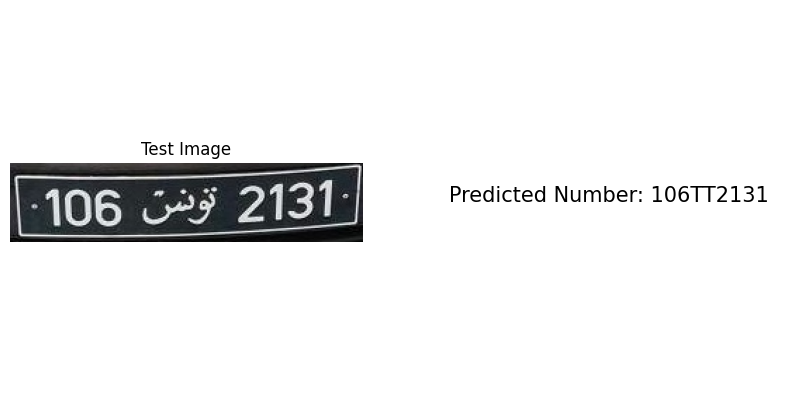

In [9]:
import torch
from efficientnet_pytorch import EfficientNet
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

# Define the alphabet and <blank> character for CTC loss
alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Example for alphanumeric license plates
alphabet = list(alphabet) + ['<blank>']

# Define transformations to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the trained model
class EfficientNetOCR(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetOCR, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.seq_head = nn.Sequential(
            nn.Linear(self.backbone._fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = x.view(x.size(0), -1, x.size(1))  # Reshape to (batch_size, seq_len, num_features)
        x = self.seq_head(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetOCR(num_classes=len(alphabet)).to(device)

# Load the model state_dict
model.load_state_dict(torch.load('/content/efficientnet_ocr.pth'))
model.eval()  # Set model to evaluation mode

# Function to decode the prediction
def decode_prediction(pred_indices):
    pred_text = ''.join([alphabet[idx.item()] for idx in pred_indices if idx != alphabet.index('<blank>')])
    return pred_text

# Inference function
def infer(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        # Get model output (seq_len, batch_size, num_classes)
        output = model(image)
        output = output.permute(1, 0, 2)  # Change shape from (batch_size, seq_len, num_classes) to (seq_len, batch_size, num_classes)

        # Perform greedy decoding (take the max index for each time step)
        pred_indices = output.argmax(dim=2)  # Get indices of max log probability

        # Decode the predicted sequence
        predicted_text = decode_prediction(pred_indices.squeeze(1))  # Remove batch dimension

    return predicted_text

# Test the model on a single image
image_path = '/content/dataset/recognition/102.jpg'  # Replace with your image path
predicted_number = infer(model, image_path)

# Display the result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.5, 0.5, f"Predicted Number: {predicted_number}", fontsize=15, ha='center')
plt.axis('off')

plt.show()


In [ ]:
## Evaluation

In [10]:
import torch
from efficientnet_pytorch import EfficientNet
import cv2
import os
import pandas as pd
from pathlib import Path
from ultralytics import YOLO  # Assuming you are using YOLOv8's Python interface
from torchvision import transforms
from PIL import Image

# Define the alphabet and <blank> character for CTC loss
alphabet = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Example for alphanumeric license plates
alphabet = list(alphabet) + ['<blank>']

def safe_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std = 1  # Prevent division by zero
    return (tensor - mean) / std

# Define transformations to resize and normalize the images for EfficientNet
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.0, 0.0], std=[0.229, 0.0, 0.0]),
    transforms.Lambda(lambda x: safe_normalize(x)),
])

# Load the trained EfficientNet model
class EfficientNetOCR(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetOCR, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.seq_head = nn.Sequential(
            nn.Linear(self.backbone._fc.in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = x.view(x.size(0), -1, x.size(1))  # Reshape to (batch_size, seq_len, num_features)
        x = self.seq_head(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetOCR(num_classes=len(alphabet)).to(device)
model.load_state_dict(torch.load('efficientnet_ocr.pth'))
model.eval()  # Set model to evaluation mode

# Load YOLOv8 model (replace with your model path)
yolo_model = YOLO('/content/runs/detect/train/weights/best.pt')  # Replace with your yolov8 weights path

# Function to decode the prediction from EfficientNet model
def decode_prediction(pred_indices):
    pred_text = ''.join([alphabet[idx.item()] for idx in pred_indices if idx != alphabet.index('<blank>')])
    return pred_text

# Inference function for text recognition on detected plates
def infer(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

    with torch.no_grad():
        # Get model output (seq_len, batch_size, num_classes)
        output = model(image)
        output = output.permute(1, 0, 2)  # Change shape from (batch_size, seq_len, num_classes) to (seq_len, batch_size, num_classes)

        # Perform greedy decoding (take the max index for each time step)
        pred_indices = output.argmax(dim=2)  # Get indices of max log probability

        # Decode the predicted sequence
        predicted_text = decode_prediction(pred_indices.squeeze(1))  # Remove batch dimension

    return predicted_text

# Function to detect the number plate and run text recognition
def detect_and_recognize(model, yolo_model, image_path):
    # Load image using OpenCV
    img = cv2.imread(image_path)  # This reads the image correctly for OpenCV processing

    # Use YOLOv8 to detect the number plate (assuming it returns a list of bounding boxes)
    results = yolo_model(image_path)  # Run YOLOv8 inference on the image

    # Debugging: Print the structure of YOLOv8 results
    print("YOLOv8 results:", results)

    # Assuming results is a list of detections and we want to extract the boxes
    # The boxes are typically in the results[0] but let's verify the correct structure
    if isinstance(results, list) and len(results) > 0:
        detection = results[0]  # YOLOv8 results are often in a list format

        # Check if the detection has the expected attributes
        if hasattr(detection, 'boxes'):
            boxes = detection.boxes  # Extract boxes if the attribute is available
            print("Detected boxes:", boxes)
        else:
            print("No boxes attribute found in YOLO results.")

        # Check if boxes are available
        if len(boxes) == 0:
            return None  # No plates detected

        # Filter for number plates (assuming '0' is the class ID for number plates)
        plates = boxes.xyxy
        #plates = boxes[boxes[:, 5] == 0]  # Class ID 0 for 'number_plate'
        if len(plates) == 0:
            return None  # If no number plates detected, return None

        # Take the first detected plate for simplicity
        x1, y1, x2, y2 = map(int, plates[0][:4])  # Extract coordinates

        # Crop the detected number plate region from the image
        plate_img = img[y1:y2, x1:x2]
        cv2.imwrite('temp.png',plate_img)

        # Convert the cropped image to a format suitable for text recognition
        #plate_img_pil = Image.fromarray(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))

        # Run text recognition on the cropped plate using the EfficientNet model
        number_plate_text = infer(model, 'temp.png')

        return number_plate_text
    else:
        print("YOLO results are not in the expected format.")
        return None

# Iterate over the images in the test folder and process them
test_folder = '/content/dataset/test/test/test'  # Folder containing the images
output_data = []

for img_file in os.listdir(test_folder):
    if img_file.endswith(('jpg', 'jpeg', 'png')):
        img_path = os.path.join(test_folder, img_file)
        print(f"Processing {img_file}...")

        # Run detection and recognition
        recognized_text = detect_and_recognize(model, yolo_model, img_path)

        if recognized_text:
            # Save img_id (filename) and recognized text to output data
            output_data.append([img_file, recognized_text])
        else:
            # If no number plate was detected, add NaN for text
            output_data.append([img_file, "No plate detected"])

# Create a DataFrame from the output data and save it as CSV
output_df = pd.DataFrame(output_data, columns=['img_id', 'number_plate_text'])
output_df.to_csv('output.csv', index=False)
print("Inference complete. Results saved to output.csv.")


Streaming output truncated to the last 5000 lines.
Speed: 3.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
YOLOv8 results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[ 71,  84,  92],
        [ 65,  78,  86],
        [126, 139, 147],
        ...,
        [231, 209, 191],
        [230, 207, 191],
        [241, 221, 204]],

       [[ 69,  82,  90],
        [ 88, 101, 109],
        [153, 166, 174],
        ...,
        [234, 212, 194],
        [234, 214, 197],
        [232, 212, 195]],

       [[ 52,  65,  73],
        [126, 139, 147],
        [134, 147, 155],
        ...,
        [237, 215, 197],
        [249, 229, 212],
        [232, 214, 197]],

       ...,

       [[135, 157, 175],
        [166, 190, 212],
        [144, 174, 201],
        ...,
        [180, 207, 228],
        [193, 217, 239],
       